# Maximize and compare the accuracy of the following extractive summarization models: keyBERT, SciBERTSUM, MemSum

Project work to complete the exam in [Text Mining by Prof. Gianluca Moro in the AC 2022/23 in Bologna](https://www.unibo.it/en/teaching/course-unit-catalogue/course-unit/2022/446610).

The dataset is given and already divided into train, test and validation. The models have two targets to predict: relevant sentences and the relevant tokens. The accuracy on both targets should be maximized. The models to be used are:

* [MemSum](https://github.com/nianlonggu/memsum)
* [SciBERTSUM](https://github.com/atharsefid/SciBERTSUM)
* [keyBERT](https://github.com/MaartenGr/KeyBERT)
  * Simply the relevant sentences to be extracted will be those containing at least k relevant tokens, with k = 1, 2 or 3 that is an hyper parameter to be tuned.

The project should be developed in colab with code commented in such a way that every step is understandable even without your verbal explanation in the discussion session.

### Task description

A dataset of social media-like dialoge is given with a ground truth of the sentences and the tokens (of the sentences) most relevant.

The task is now to use different models trained on summarization, adapt them to the dataset given and compare their performance on the tasks of

* extractive summarization
* keyword generation



### Metrics

* ROUGE-N for MemSum, keyBERT [see](https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460)

### Multi-step Episodic Markov decision process extractive SUMmarizer (MemSum)

Based on reinforcement-learning episodic Markov decision processes, this extractive summarizer uses at each step

1. the text context of the sentence
2. the global text context (!)
3. and the extraction history (!)

While iteratively selecting further sentences to extract, it also auto-selects the stop state. It produces concise summaries with little redudancy.

Even though that the model is lightweight, it has SOTA performance on long documents from PubMed, arXiv, and GovReport


### SciBERTSUM

Extends BERTSUM by

1. adding a section embedding layer to include section information in the sentence vector
2. applying a sparse attention mechanism where each sentence will attend locally to nearby sentences and (randomly) to a small number of global sentences




### keyBERT

Uses BERT embeddings and pretrained models. Then extracts keyword n-gram candidates and with cosine similarity and diversification selects the best keywords.

### Summary

Model | Technology | performance | context | history | trained on
---|---|---|---|---|---
MemSum | Markov decision processes | xy | local, global | extraction | arXiv, PubMed, GovReport
SciBERTSUM | BERT with attention | xy | local, global | no | articles with presentation slides as ground truth
keyBERT | BERT embeddings with cosine similarity | xy | cosine similarity, diversification | in diversification | own

### Expected results

* MemSum, SciBERTSUM should be very good for long texts
* MemSum should generate short summaries compared to other models, less redundant
* keyBERT should be fast

## Preparation

[Recommendations how to install packages](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/)

In [1]:
# !python3 -m venv env/ # only if you don't have a virtual environment
!source env/bin/activate

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/cu116/torch_stable.html


In [3]:
import os
import numpy as np
import pandas as pd
import config 
import json
import torch
import logging

# utils module
import data_preparation

# parsing
import stanza

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Installing the extractive summarization models

### Computing some summary statistics about the dataset

- [ ] how long are the texts: train, test, val - how long is the longest
- [ ] how long are the relevant sentences 

In [4]:
# set the working directory to ENV_PATH
os.chdir(config.ENV_PATH)

# visualize the data
path_to_metadata = os.path.join(config.DATA_PATH, 'metadata.csv')
if not os.path.isfile(path_to_metadata):
    data_preparation.computing_metadata(path_to_metadata)
metadata = pd.read_csv(path_to_metadata)


2023-02-22 10:43:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-02-22 10:43:03 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-02-22 10:43:03 INFO: Use device: gpu
2023-02-22 10:43:03 INFO: Loading: tokenize
2023-02-22 10:43:05 INFO: Done loading processors!


Start preprocessing test
Start preprocessing train
Start preprocessing val


In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16366 entries, 0 to 16365
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         16366 non-null  object 
 1   n_dialogues                  16366 non-null  int64  
 2   n_sentences_dialogue         16366 non-null  int64  
 3   n_tokens_dialogue            16366 non-null  int64  
 4   n_tokens_per_sentence        16366 non-null  float64
 5   n_extracts_per_summary_rel   16366 non-null  int64  
 6   n_tokens_per_extract_rel     16366 non-null  float64
 7   n_extracts_per_summary_fine  16366 non-null  int64  
 8   n_tokens_per_extract_fine    16366 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 1.1+ MB


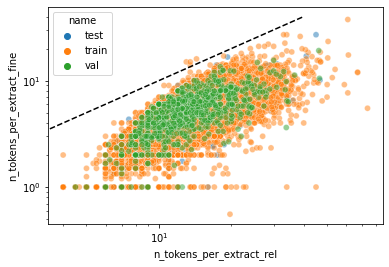

In [40]:
sns.kdeplot(data=metadata, x='n_sentences_dialogue', hue='name', 
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()
sns.kdeplot(data=metadata, x='n_tokens_dialogue', hue='name',
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()
sns.kdeplot(data=metadata, x='n_tokens_per_sentence', hue='name',
            log_scale=True, common_norm=False, alpha=0.5)
plt.show()

sns.scatterplot(data=metadata, x='n_sentences_dialogue', y='n_tokens_dialogue', hue='name')
plt.show()
sns.scatterplot(data=metadata, x='n_extracts_per_summary_rel', y='n_extracts_per_summary_fine', hue='name')
plt.show()
sns.scatterplot(data=metadata, x='n_tokens_per_extract_rel', y='n_tokens_per_extract_fine', hue='name',
                alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.plot([0, 40], [0, 40], color='black', linestyle='--')
# plot a line parallel to the x-axis # TODO, does not work...
plt.axhline(y=0.)
plt.show()

### MemSum

The model expects:

- [x] download the pretrained word embeddings
- [x] The training data is now stored in a .jsonl file that contains a list of json info, one line for one training instance. Each json (or dictonary) contains two keys:
  1. "text": the value for which is a python list of sentences, this represents the document you want to summarize;
  2. "summary": the value is also a list of sentences. If represent the ground-truth summary. Because the summary can contain multiple sentences, so we store them as a list.
- [x] repeat for not-training corpus
- [x] high-ROUGE episodes for the training set
- [x] download glove into the `model/glove/` folder

- [ ] we need to furthermore make a dataset with all the tokes instead of sentences as the basic thing


In [7]:
# download the pretrained word embeddings
!mkdir -p MemSum-015ddda/model && cd MemSum-015ddda/model && gdown https://drive.google.com/drive/folders/1lrwYrrM3h0-9fwWCOmpRkydvmF6hmvmW --folder

Retrieving folder list
Processing file 1SVTHcgWJDvoVCsLfdvkaw5ICkihjUoaH unigram_embeddings_200dim.pkl
Processing file 1SuF4HSe0-IBKWGtc1xqlzMHNDneiLi4- vocabulary_200dim.pkl
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1SVTHcgWJDvoVCsLfdvkaw5ICkihjUoaH
To: /home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda/model/glove/unigram_embeddings_200dim.pkl
100%|████████████████████████████████████████| 320M/320M [00:06<00:00, 52.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SuF4HSe0-IBKWGtc1xqlzMHNDneiLi4-
To: /home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda/model/glove/vocabulary_200dim.pkl
100%|██████████████████████████████████████| 4.16M/4.16M [00:00<00:00, 22.4MB/s]
Download completed


In [8]:
# get and run Stanford CoreNLP
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# new files only if not already downloaded
!wget -nc "https://nlp.stanford.edu/software/stanford-corenlp-latest.zip"
!unzip -n "stanford-corenlp-latest.zip"

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
File ‘stanford-corenlp-latest.zip’ already there; not retrieving.

Archive:  stanford-corenlp-latest.zip


In [9]:
os.chdir(os.path.join(config.ENV_PATH,'MemSum-015ddda'))
os.getcwd()

'/home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda'

In [10]:
# preprocessing custom data
from data_preparation import preprocessing_memsum_data_sentences

memsum_datasets = [config.name_trainset, config.name_valset, config.name_testset]

! mkdir -p data/

for d in memsum_datasets:
    data_preparation.preprocessing_memsum_data_sentences(d)

    # check if the preprocessing worked
    corpus = [ json.loads(line) for line in open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('memsum_sentences_' + d + ".jsonl"))) ]
    print(f"For the {d} corpus of length {len(corpus)} we have the keys {corpus[0].keys()}")
    print(corpus[0]["text"][:3])
    print(corpus[0]["summary"][:3])
    print("-----------------------------------\n")

    data_path = f"../data/memsum_sentences_{d}.jsonl"

    ! cp $data_path data/

2023-02-22 11:02:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-02-22 11:02:13 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-02-22 11:02:13 INFO: Use device: gpu
2023-02-22 11:02:13 INFO: Loading: tokenize
2023-02-22 11:02:13 INFO: Done loading processors!


For the train corpus of length 14729 we have the keys dict_keys(['text', 'summary'])
[' Amanda: I baked  cookies. Do you want some?', ' Jerry: Sure!', " Amanda: I'll bring you tomorrow :-)"]
[' Amanda: I baked  cookies. Do you want some?', " Amanda: I'll bring you tomorrow :-)"]
-----------------------------------



2023-02-22 11:02:14 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-02-22 11:02:14 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-02-22 11:02:14 INFO: Use device: gpu
2023-02-22 11:02:14 INFO: Loading: tokenize
2023-02-22 11:02:14 INFO: Done loading processors!


For the val corpus of length 818 we have the keys dict_keys(['text', 'summary'])
[' A: Hi Tom, are you busy tomorrow’s afternoon?', ' B: I’m pretty sure I am. What’s up?', ' A: Can you go with me to the animal shelter?.']
[' A: Hi Tom, are you busy tomorrow’s afternoon?', ' A: Can you go with me to the animal shelter?.', ' A: I want to get a puppy for my son.']
-----------------------------------



2023-02-22 11:02:15 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-02-22 11:02:15 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2023-02-22 11:02:15 INFO: Use device: gpu
2023-02-22 11:02:15 INFO: Loading: tokenize
2023-02-22 11:02:15 INFO: Done loading processors!


For the test corpus of length 819 we have the keys dict_keys(['text', 'summary'])
[" Hannah: Hey, do you have Betty's number?", ' Amanda: Lemme check', ' Hannah: <file_gif>']
[" Hannah: Hey, do you have Betty's number?", " Amanda: Sorry, can't find it.", ' Amanda: Ask Larry']
-----------------------------------



In [11]:
from src.data_preprocessing.MemSum.utils import greedy_extract
import json
from tqdm import tqdm

train_corpus = [ json.loads(line) for line in open("data/memsum_sentences_train.jsonl") ]
for data in tqdm(train_corpus):
    high_rouge_episodes = greedy_extract(data["text"], data["summary"], beamsearch_size = 2)
    indices_list = []
    score_list  = []

    for indices, score in high_rouge_episodes:
        indices_list.append( indices )
        score_list.append(score)

    data["indices"] = indices_list
    data["score"] = score_list

100%|██████████| 14729/14729 [14:58<00:00, 16.39it/s]


In [12]:
with open("data/memsum_sentences_train_labelled.jsonl","w") as f:
    for data in train_corpus:
        f.write(json.dumps(data) + "\n")

### SciBERTSum

- [ ] what is the maximum length of the tokens in the text? If $>512$, then set `max_pos` to this value
- [ ] 

In [13]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Unfortunately, I cannot download the pre-processed data because of a google drive error. [Try again later](https://drive.google.com/file/d/1xYHXYoQBa7DJVrq0ePly58ioq2EmmVG8/view)

### keyBERT

According to the documentation one should not do preprocessing.

- [x] keyBERT wants the data as a list of documents
- [x] `CountVectorizer` to remove stop words and specify the length of the keywords
- [x] `sentence-transformers` to create high-quality embeddings
- [x] calculate the cosine similarity between candidates and the document
- [x] trade-off accuracy and diversity to better represent the whole document

In [14]:
! pip show keybert

Name: keybert
Version: 0.7.0
Summary: KeyBERT performs keyword extraction with state-of-the-art transformer models.
Home-page: https://github.com/MaartenGr/keyBERT
Author: Maarten Grootendorst
Author-email: maartengrootendorst@gmail.com
License: UNKNOWN
Location: /home/work/.local/lib/python3.8/site-packages
Requires: sentence-transformers, rich, scikit-learn, numpy
Required-by: 


In [15]:
import pickle

# preprocessing custom data
def preprocessing_keybert_data_tokens(name_dataset):
    with open(os.path.join(config.ENV_PATH, config.DATA_PATH, name_dataset + '.json')) as f:
        json_data = json.load(f)

    keybert_docs, keybert_keywords = [], []

    for l in json_data:
        keybert_docs.append(l['dialogue'])
        keybert_keywords.append(l['finegrained_relevant_dialogue'])

    keybert_docs_path = os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_docs_' + name_dataset + ".txt"))
    keybert_keywords_path = os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_keywords_' + name_dataset + ".txt"))
    with open(keybert_docs_path, 'wb') as outfile_docs:
        pickle.dump(keybert_docs, outfile_docs)
    with open(keybert_keywords_path, 'wb') as outfile_keywords:
        pickle.dump(keybert_keywords, outfile_keywords)

keybert_datasets = [config.name_trainset, config.name_valset, config.name_testset]

for d in keybert_datasets:
    preprocessing_keybert_data_tokens(d)

- [ ] token limit? then split the documents into paragraphs and use mean pooling for the resulting vector

The resulting keywords are n-grams of different size. But if we get the range of the keywords we can directly use the parameter `keyphrase_ngram_range` to feed it into `keyBERT`. BUT as one can see from below, it is not really practical to have a $61$-gram.

In [16]:
with open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_keywords_' + "train" + ".txt")), 'rb') as f:
    train_keywords = pickle.load(f)

with open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_keywords_' + "test" + ".txt")), 'rb') as f:
    test_keywords = pickle.load(f)

with open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_keywords_' + "val" + ".txt")), 'rb') as f:
    val_keywords = pickle.load(f)

longest_ngram_train = 0
longest_ngram_train_text = ''
for i in train_keywords:
    for j in i:
        if len(j.split(' ')) > longest_ngram_train:
            longest_ngram_train = len(j.split(' '))
            longest_ngram_train_text = j
print(longest_ngram_train_text)
print(longest_ngram_train, '\n')

longest_ngram_test = 0
longest_ngram_test_text = ''
for i in test_keywords:
    for j in i:
        if len(j.split(' ')) > longest_ngram_test:
            longest_ngram_test = len(j.split(' '))
            longest_ngram_test_text = j
print(longest_ngram_test_text)
print(longest_ngram_test, '\n')

longest_ngram_val = 0
longest_ngram_val_text = ''
for i in val_keywords:
    for j in i:
        if len(j.split(' ')) > longest_ngram_val:
            longest_ngram_val = len(j.split(' '))
            longest_ngram_val_text = j
print(longest_ngram_val_text)
print(longest_ngram_val, '\n')


now it has a crack on it, my heel broke as I was leaving to work so i had to go back to change causing me to be late to work, some *idiot* spilt coffee all over my presentation notes and because Malcome is such a jackass, of course he thought that making copies was *optional* even though it's his job
61 

googled me out, because he thought that i had a crush on him, because 2 weeks earlier  I LIKED A POST ON FB announcing that he was going to accompany poets on the guitar during the poetry reading
39 

can even go and work in the petrol station till 10pm and pop home on the late train if I want to, saves me food money to have a day or two of home cooking, plus it's a lot nicer
40 



Given the [choices of bert models](https://www.sbert.net/docs/pretrained_models.html), the passage models (queries from bing -> relevant passages) make the most sense. To compare to the other publications, also the model trained on scientific citations can be used. The following models make sense:

* `paraphrase-distilroberta-base-v2`: should perform well according to the docs
* `msmarco`: passage ranking looks similar, here we use different versions
* `specter`: trained on scientific citations

In [17]:
from keybert import KeyBERT

# hyperparameters
keyphrase_ngram_range = (1, 4)
maxsum_args = {'use_maxsum': True, 'nr_candidates': 20, 'top_n': 5} # `MaxSumSimilarity` with `nr_candidates` $< 20%$ of total number of unique words
mmr_args = {'use_mmr': True, 'diversity': 0.7}
model = 'paraphrase-distilroberta-base-v2' # "all-MiniLM-L6-v2" # stick to sentence transformers models as they are optimized, also the models using cosine similarity
# 'msmarco-MiniLM-L6-cos-v5', 'msmarco-MiniLM-L12-cos-v5', 'msmarco-distilbert-cos-v5', 'allenai-specter', 'paraphrase-distilroberta-base-v2'
shared_args = {'keyphrase_ngram_range': keyphrase_ngram_range, 'stop_words': 'english',}

# load data
with open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_docs_' + "train" + ".txt")),'rb') as f:
    train_docs = pickle.load(f)

with open(os.path.join(config.ENV_PATH, config.DATA_PATH, str('keybert_token_keywords_' + "train" + ".txt")), 'rb') as f:
    train_keywords = pickle.load(f)

# for testing
doc = train_docs[0]
keywords = train_keywords[0]

# model
kw_model = KeyBERT(model=model)

# prepare embeddings to save time when changeing hyperparameters
# use docs instead of doc in production
doc_embeddings, word_embeddings = kw_model.extract_embeddings(doc,
                                                              **shared_args)
                                                            #   keyphrase_ngram_range=keyphrase_ngram_range,  
                                                            #   stop_words='english')

keywords_candidates = kw_model.extract_keywords(doc,
                                                doc_embeddings=doc_embeddings, word_embeddings=word_embeddings,
                                                highlight=True,
                                                **shared_args,
                                                **maxsum_args,)

print(keywords)
print(keywords_candidates)

2023-02-22 11:17:20.356318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 11:17:20.739901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ThirdParty-9/platforms/linux64Gcc/gperftools-svn/lib:/opt/openfoam9/platforms/linux64GccDPInt32Opt/lib/paraview-5.6:/opt/paraviewopenfoam56/lib:/opt/openfoam9/platforms/linux64GccDPInt32Opt/lib/openmpi-system:/opt/ThirdParty-9/platforms/linux64GccDPInt32/lib/openmpi-system:/usr/lib/x86_64-linux-gnu/openmpi/lib:/home/work/OpenFOAM/work-9/platforms/linux64GccDPInt32Opt/lib:/opt/site/9/platfo

Amanda baked cookies Do you you want some Jerry Sure Amanda ll bring you tomorrow

['baked  cookies', "'ll bring you tomorrow"]
[('amanda ll bring', 0.2079), ('want jerry sure amanda', 0.2348), ('ll bring tomorrow', 0.3243), ('cookies', 0.3588), ('baked cookies', 0.4457)]


Problem: The model is of a form such that the phrase `'ll bring you tomorrow` is not even part of the candidates.

## Training the models on the new data

### MemSum

Note:
1. you need to switch to the folder src/MemSum_Full;
2. You can specify the path to training and validation set, the model_folder (where you want to store model checkpoints) and the log_folder (where you want to store the log info), and other parameters. 
3. You can provide the absolute path, or relative path, as shown in the example code below.
4. n_device means the number of available GPUs

In [18]:
path_to_memsum_training = os.path.join(config.ENV_PATH, "MemSum-015ddda/", "src/MemSum_Full/")

In [41]:
# hyperparameters
max_seq_len = 100 
max_doc_len = 500
num_of_epochs = 10 
max_extracted_sentences_per_document = 7
moving_average_decay = 0.999
p_stop_thres = 0.6

# available GPU devices
if torch.cuda.is_available():
    print('GPU available!')
    print(f"Total number of available devices: {torch.cuda.device_count()}")
    device = torch.device(0)
    n_device = torch.cuda.device_count()
    batch_size_per_device = 1 # maximum my device supports, for 2 it dies after 5it
else:
    print('GPU not available.')
    device = torch.device('cpu')
    n_device = 0

# paths to data
memsum_training_corpus = os.path.join(config.ENV_PATH, "MemSum-015ddda/", "data/memsum_sentences_train_labelled.jsonl")
memsum_val_corpus = os.path.join(config.ENV_PATH, "MemSum-015ddda/", "data/memsum_sentences_val.jsonl")

!cd $path_to_memsum_training && python3 train.py -training_corpus_file_name $memsum_training_corpus -validation_corpus_file_name $memsum_val_corpus -model_folder ../../model/MemSum_Full/custom_data/200dim/run0/ -log_folder ../../log/MemSum_Full/custom_data/200dim/run0/ -vocabulary_file_name ../../model/glove/vocabulary_200dim.pkl -pretrained_unigram_embeddings_file_name ../../model/glove/unigram_embeddings_200dim.pkl -max_seq_len $max_seq_len -max_doc_len $max_doc_len -num_of_epochs $num_of_epochs -save_every 200 -n_device $n_device -batch_size_per_device $batch_size_per_device -max_extracted_sentences_per_document $max_extracted_sentences_per_document -moving_average_decay $moving_average_decay -p_stop_thres $p_stop_thres

GPU available!
Total number of available devices: 1
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
14729it [00:00, 86681.98it/s]
818it [00:00, 162165.75it/s]
0it [00:00, ?it/s]
Traceback (most recent call last):
  File "train.py", line 361, in <module>
    loss = train_iteration(batch)
  File "train.py", line 222, in train_iteration
    local_sen_embed = local_sentence_encoder( seqs.view(-1, seqs.size(2) ) , dropout_rate )
  File "/home/work/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/work/Dokumente/Studium/SimTech_MSc/Erasmus/Lectures/Text_mining/project/ExtractiveSummaryModels/MemSum-015ddda/src/MemSum_Full/mode

## Tuning the model hyperparameters, if applicable

### MemSum

* num_heads: (int, default = 8
* hidden_dim: (int, default = 1024
* N_enc_l: (int, default = 3
* N_enc_g: (int, default = 3
* N_dec: (int, default = 3
* max_seq_len: (int, default = 100
* max_doc_len: (int, default = 50
* num_of_epochs: (int, default = 50
* print_every: (int, default = 100
* save_every: (int, default = 500
* validate_every:  (int, default= 1000
* restore_old_checkpoint: (bool, default = True)
* learning_rate: (float, default = 1e-4
* warmup_step:  (int, default= 1000
* weight_decay: (float, default = 1e-6)
* dropout_rate: (float, default = 0.1)
* n_device: (int, default = 8)
* batch_size_per_device: (int, default = 16)
* max_extracted_sentences_per_document: (int)
* moving_average_decay: (float)
* p_stop_thres: (float, default = 0.7
* apply_length_normalization: (int, default = 1

### SciBERTSUM

* attention mechanism
* paper: learning rate is one of the most important hyper-parameters to tune

### keyBERT

* different embeddings
* number of keywords extracted, n-gram range (for keyphrases)

## Comparing the models

* what is the length of the summaries the models produce?
* for human experts three criteria: non-redundancy, coverage, and overall quality
* model runtimes

## Summary and Conclusion

## Citations

* Nianlong Gu, Elliott Ash, and Richard Hahnloser. 2022. [MemSum: Extractive Summarization of Long Documents Using Multi-Step Episodic Markov Decision Processes.](https://aclanthology.org/2022.acl-long.450) In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 6507–6522, Dublin, Ireland. Association for Computational Linguistics.
* Sefid, Athar, and C. Lee Giles. [SciBERTSUM: Extractive Summarization for Scientific Documents.](https://doi.org/10.1007/978-3-031-06555-2_46) Document Analysis Systems: 15th IAPR International Workshop, DAS 2022, La Rochelle, France, May 22–25, 2022, Proceedings. Cham: Springer International Publishing, 2022.
* Grootendorst, Maarten. [KeyBERT: Minimal keyword extraction with BERT.](https://doi.org/10.5281/zenodo.4461265) Zenodo (2020).